## KMeans Clustering in 6 Dimensions to sample phase space 

### Short Version: 
> We will explore KMeans and KMeans Minibatch. KMeans Minibatch is faster, use that. KMeans++ is a default input parameter for both and is optimal for fast and accurate clustering.

### Long Version: 
* [How does KMeans work?](#first-bullet)
* [How does KMeans MiniBatch work?](#second-bullet)
* [Runtime Comparison Between KMeans & KMeans MiniBatch](#third-bullet)

KMeans++ ensures that the initial points chosen for Kmeans(Minibatch or not) are far apart which is good cause randomly chosen points can be close together (bad for clustering purposes).






### How does KMeans work?<a class="anchor" id="first-bullet"></a>

First off, why do we choose KMeans clustering?
Below is an image of the various machine learning clustering algorithms by [scikit-learn](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py):

<img src="Defining_kmeans_images/clustering_algorithm_comparison.png">

We choose KMeans Clustering for 3 main reasons (ranked by importance):

1. Fast Runtime. KMeans itself is quite fast. It runs linear in Big O: O(kN), where k - # of iterations (KMeans is an iterative process) and N - # of datapoints.  Additionally, there is a variant called KMeans MiniBatch which is optimized to run fast with large datasets using a gradient descent optimization process.


2. Good Clustering. Although there are many ways to cluster, we expect our data to model a relatively random distribution as shown in the third row.


3. Number of Clusters Centres. Since we want to sample from our dataset, we  want to be able to specify how many clusters, and ultimately cluster centres we want the algorithm to output. KMeans allows that.

Secondly, to understand how KMeans Clustering works, we need to understand how Voronoi Tesselations work.

The idea of [Voronoi Tesselations/Voronoi Diagram](https://en.wikipedia.org/wiki/Voronoi_diagram) is quite simple. Consider an example below:

<img src="Defining_kmeans_images/voronoi_tesselation.png">

The input of a Voronoi Tesselation are the datapoints, say in a cartesian plane. From this, a partitioning is made such that for every point in a region, the datapoint (black dot) is the closest to that point. In other words, the borders of the partition is equidistance between 2 datapoints and the vertices are equidistanct between at least 3 datapoints.

Now, I will explain how KMeans clustering works. 

<img src="Defining_kmeans_images/kmeans_explained.png">

Step 1: Initialize fake cluster centres. The grey squares are datapoints and coloured circles are randomly chosen cluster centres. 

Step 2: Create a Voronoi Tesselation of the fake cluster centres.

Step 3: Calculate the centroid of each region in the Voronoi Tesselation. Move the fake cluster centres to the location of the centroid. 

Step 4: Repeat Steps 2 & 3 until convergence occurs and the cluster centres no longer move. Now the initial fake cluster centres have moved to where the cluster centres should be.

Now this is just the bare bones of how KMeans work. Here are the details.

1. Inertia. We can calculate the quality of the generated cluster centres by an outpute parameter interia. Inertia is defined as the sum of square distances of samples to their nearest cluster centre. In scikit's implementation of KMeans, the whole algorithm is run 10 times by default and the final output is chosen by the lowest inertia value. This means cluster centres are good representations of the data.


2. KMeans++ This is a short algorithm to optimize Step 1 by creating fake cluster centres that are far apart. This is good as we want dense regions to be represented by only 1 cluster centre. KMeans++ also decreases runtime as since the starting position is good, there will be less iterations required on average.

We will first use KMeans to perform clustering on just the x & y values of our 6D Gaia DR2 RV dataset.

In [207]:
import sys
sys.path.append("..") # lets you import from outer folder
from search import search_local # imports module within search folder
samples = search_local.search_phase_space(0, 0, 0, 0, 0, 0, epsilon=0.3, v_scale=0.1)
len(samples)

207

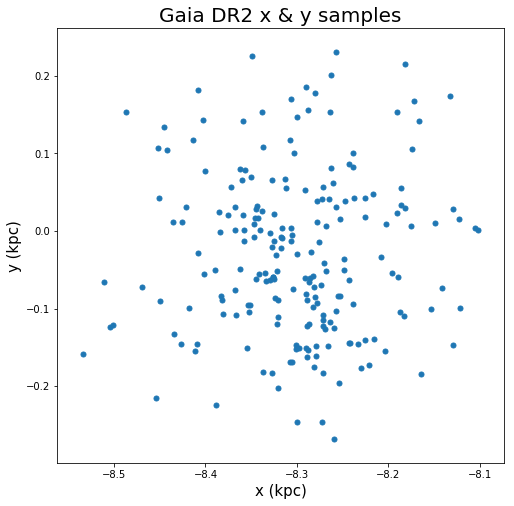

In [208]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
plt.scatter(samples[:,0], samples[:,1], s=25)
plt.title("Gaia DR2 x & y samples", fontsize=20)
plt.xlabel('x (kpc)', fontsize = 15)
plt.ylabel('y (kpc)', fontsize = 15)
plt.show()

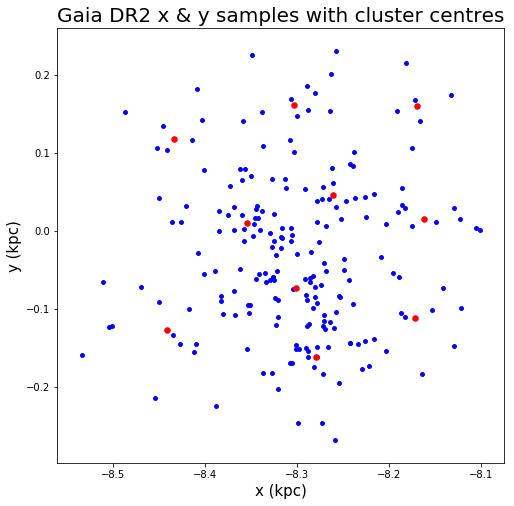

In [209]:
from sklearn.cluster import KMeans

my_kmeans = KMeans(n_clusters=10)  # create KMeans object
my_kmeans.fit(samples[:, :2])  # perform KMeans fitting function

fig = plt.figure(figsize=(8, 8))
plt.scatter(samples[:,0], samples[:,1], s=15, c='blue')
plt.scatter(my_kmeans.cluster_centers_[:, 0],
            my_kmeans.cluster_centers_[:, 1],s=30, c='red')
plt.title("Gaia DR2 x & y samples with cluster centres", fontsize=20)
plt.xlabel('x (kpc)', fontsize = 15)
plt.ylabel('y (kpc)', fontsize = 15)
plt.show()

Above in red are the clusters that the KMeans algorithm produced.
You may be wondering how the Voronoi Tesselations end up. Below is the same plot except cluster centres are denoted by black crosses, and each data point is color-coded to show different regions in the Voronoi Tesselation.

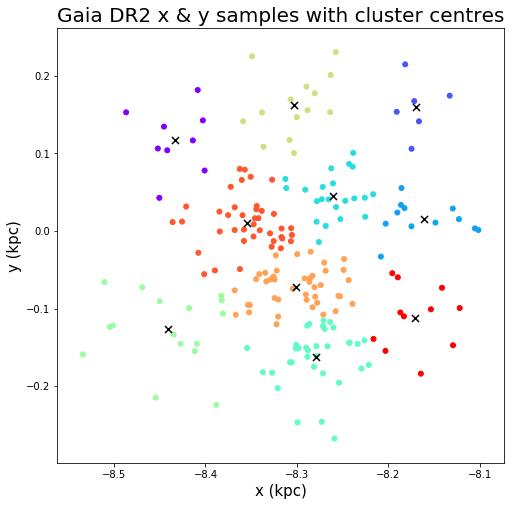

In [210]:
import numpy as np

cmap = plt.get_cmap("rainbow")
colours = cmap(np.linspace(1, 0, 10))

fig = plt.figure(figsize=(8, 8))
plt.scatter(samples[:,0], samples[:,1], s=25, c=colours[my_kmeans.labels_])
plt.scatter(my_kmeans.cluster_centers_[:, 0],
            my_kmeans.cluster_centers_[:, 1], s = 50, marker='x', c='black')
plt.title("Gaia DR2 x & y samples with cluster centres", fontsize=20)
plt.xlabel('x (kpc)', fontsize=15)
plt.ylabel('y (kpc)', fontsize=15)
plt.show()

Let's add the z dimension and visualize this in 3D

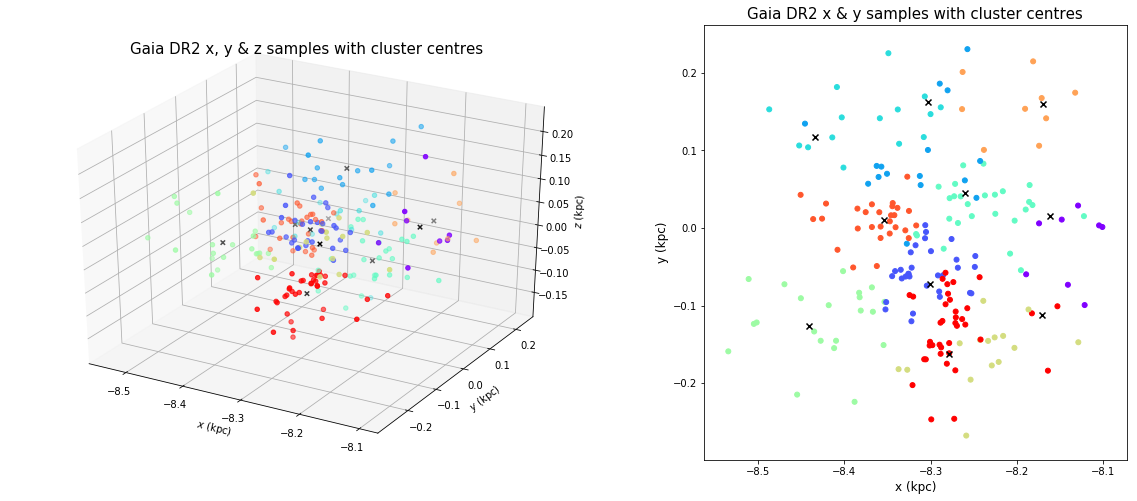

In [235]:
from mpl_toolkits.mplot3d import Axes3D

my_kmeans_3D = KMeans(n_clusters=10)
my_kmeans_3D.fit(samples[:, :3])

fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.4, 1]) 

ax = fig.add_subplot(gs[0], projection='3d')
ax.scatter(*samples.transpose()[:3], s=20, c=colours[my_kmeans_3D.labels_])
ax.scatter(*my_kmeans_3D.cluster_centers_.transpose()[:3], marker='x', c='black')
ax.set_title("Gaia DR2 x, y & z samples with cluster centres", fontsize=15)
ax.set_xlabel('$x$ (kpc)')
ax.set_ylabel('$y$ (kpc)')
ax.set_zlabel('$z$ (kpc)')

ax1 = fig.add_subplot(gs[1])
plt.scatter(samples[:,0], samples[:,1], s=25, c=colours[my_kmeans_3D.labels_])
plt.scatter(my_kmeans.cluster_centers_[:, 0],
            my_kmeans.cluster_centers_[:, 1], marker='x', c='black')
plt.title("Gaia DR2 x & y samples with cluster centres", fontsize=15)
plt.xlabel('x (kpc)', fontsize=12)
plt.ylabel('y (kpc)', fontsize=12)


plt.show()

### How does KMeans work?<a class="anchor" id="second-bullet"></a>

### Runtime Comparison Between KMeans & KMeans MiniBatch<a class="anchor" id="third-bullet"></a>

>| Sample size | Dimensions (x, y, z, vx, vy, vz) | # of Clusters | Runtime |
 | ----------- | ---------------------------------| ------------- | ------- |
 | 100     | right-aligned | $1600 |
 | col 2 is      | centered      |   $12 |
 | zebra stripes | are neat      |    $1 |

In [ ]:
my_kmeans_3D.cluster_centers_[:3]

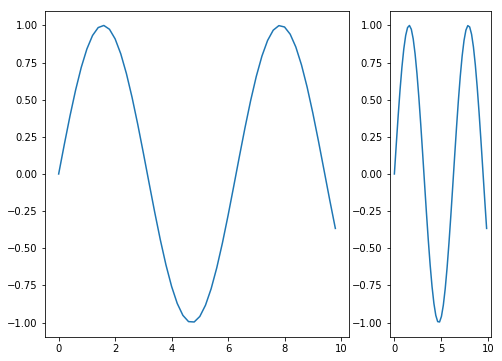

In [221]:
from matplotlib import gridspec

# generate some data
x = np.arange(0, 10, 0.2)
y = np.sin(x)

# plot it
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
ax0.plot(x, y)
ax1 = plt.subplot(gs[1])
ax1.plot(x, y)

plt.show()